# Critical Infrastructure Failures from Hurricane Michael (FL, AL, GA)
## Result Plotting Script

In [1]:
# Standard imports
import cartopy.crs as ccrs
import cartopy.util as cutil
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas as gpd
import itertools
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.colors import LogNorm, BoundaryNorm, ListedColormap, LogNorm
import matplotlib.cm as cm_mp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
import pandas as pd
import pickle
from scipy.interpolate import griddata
import seaborn as sns
import shapely

In [2]:
os.chdir('/cluster/project/climate/evelynm')
import mplotutils.mplotutils as mpu
os.chdir('/cluster/work/climate/evelynm')

In [3]:
# CLIMADA core imports
import climada.util.plot as u_plot
from climada.util.constants import SYSTEM_DIR
from climada.util.scalebar_plot import scale_bar
from climada.hazard import TCTracks, Hazard, Centroids, TropCyclone

## Data Loader

In [44]:
PATH_DATA = '/cluster/work/climate/evelynm/nw_inputs/FLALGA'
PATH_RESULTS = '/cluster/work/climate/evelynm/nw_outputs/FLALGA'
PATH_SAVE_PLOTS = '/cluster/work/climate/evelynm/nw_outputs/FLALGA/plots'
mode = 'telemod'

In [45]:
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', '50m')
border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')

In [46]:
# TC MICHAEL
tc_michael = Hazard('TC').from_hdf5(PATH_DATA+'/tc_michael_1h.hdf5')
tc_michael.check()
tr_michael = TCTracks.from_ibtracs_netcdf(
    provider='usa', storm_id='2018280N18273') # Michael 2018
tr_michael.equal_timestep()

In [47]:
# Original GDFs
gdf_people = gpd.read_file(PATH_DATA+'/people_flalga.shp')
gdf_pplants = gpd.read_file(PATH_DATA+'/powerplants_flalga.shp')
gdf_health = gpd.read_file(PATH_DATA+'/healthfacilities_flalga.shp')
gdf_educ = gpd.read_file(PATH_DATA+'/educationfacilities_flalga.shp') 
gdf_telecom = gpd.read_file(PATH_DATA+'/celltowers_flalga.shp') 
gdf_wastewater = gpd.read_file(PATH_DATA+'/wastewater_flalga.shp') 
gdf_power_edges = gpd.read_file(PATH_DATA+'/powerlines_flalga.shp')
gdf_road_edges = gpd.read_file(PATH_DATA+'/mainroads_osm_flalga.shp')

In [48]:
# Base GDF and Result GDFs in network structure
gdf_all_nodes_base = gpd.read_feather(PATH_RESULTS+f'/cis_nw_nodes_base_{mode}')
gdf_all_nodes = gpd.read_feather(PATH_RESULTS+f'/cis_nw_nodes_{mode}_tcimpacts')
gdf_all_edges = gpd.read_feather(PATH_RESULTS+f'/cis_nw_edges_{mode}_tcimpacts')

In [49]:
with open(PATH_RESULTS+f'/base_stats_FLALGA_{mode}.pkl', 'rb') as handle:
     dict_basestats = pickle.load(handle)

In [50]:
with open(PATH_RESULTS+f'/disaster_stats_{mode}.pkl', 'rb') as handle:
     dict_disasterstats = pickle.load(handle)

In [51]:
bool_people = gdf_all_nodes.ci_type=='people'
bool_hc = gdf_all_nodes.ci_type=='health'
bool_ed = gdf_all_nodes.ci_type=='education'
bool_ct = gdf_all_nodes.ci_type=='celltower'
bool_pl = gdf_all_edges.ci_type=='power_line'
bool_pln = gdf_all_nodes.ci_type=='power_line'
bool_rd = gdf_all_edges.ci_type=='road'
bool_rdn = gdf_all_nodes.ci_type=='road'
bool_ww = gdf_all_nodes.ci_type=='wastewater'
bool_pplant = gdf_all_nodes.ci_type=='power_plant'

In [52]:
dict_disasterstats

{'power': 1222393.2611204945,
 'healthcare': 808980.7721813582,
 'education': 1082257.159295734,
 'telecom': 1010831.8469913565,
 'mobility': 754976.4504514858,
 'water': 1218349.8105843626}

In [69]:
mode

'telemod'

## Result processing functions

In [59]:
def get_accessstates(gdf_results, node_gdf_orig):
    """
    1 - accessible, 0 - inaccessible from beginning on, -1 - disrupted due to 
    disaster
    Changes gdf entries.
    """
    services = [colname for colname in gdf_results.columns if 'actual_supply_' in colname] 
    for service in services:
        serv_level = gdf_results[gdf_results.ci_type=='people'][service].values
        serv_level_orig = node_gdf_orig[node_gdf_orig.ci_type=='people'][service].values
        serv_level[(serv_level==0.) & (serv_level_orig==1.)]= -1.
        gdf_results.loc[gdf_results.ci_type=='people', service] = serv_level
    return gdf_results

In [54]:
def get_cascstate(gdf):
    """
    0 - functional, 1 - directly failed, 2 - cascaded failure
    Adds column to gdf
    """
    casc_state = [0]* len(gdf)
    for i in range(len(gdf)):
        if ((gdf.func_tot.iloc[i]==0) & (gdf.func_internal.iloc[i]==0)):
            casc_state[i] = 1
        elif ((gdf.func_tot.iloc[i] ==0) & (gdf.func_internal.iloc[i] >0)):
            casc_state[i] = 2
    return casc_state

In [55]:
from collections import Counter

def count_failratios(casc_vals):
    return Counter(casc_vals)

def fail_dict(fail_counter):
    tot_vals = fail_counter[1]+fail_counter[2]
    return {'dir. fail' : f'{(fail_counter[1]/tot_vals)*100:.1f}%',
            'casc. fail': f'{(fail_counter[2]/tot_vals)*100:.1f}%'}

## Visualization Functions

In [56]:
def get_exposed_shape(hazard, thresh):
    intensity = np.array(hazard.intensity.todense()).squeeze()
    coords = np.array(hazard.centroids.coord).squeeze()
    coords_exp = np.array( [shapely.geometry.Point([geom[1], geom[0]]).buffer(0.1) 
                            for geom in coords[intensity>thresh]])
    return shapely.ops.unary_union(coords_exp)

def split_gdf_exp_unexp(gdf, shape):
    gdf_unexp = gdf[~gdf.within(shape)]
    gdf_exp = gdf[gdf.within(shape)]
    return gdf_unexp, gdf_exp


In [57]:
def exposed_unexposed_plot(ax, gdf_unexp, gdf_exp, lines=False, cmap='plasma'):
    if lines:
        plot_exp = gdf_exp.plot('imp_dir', ax=ax, linewidth=0.5, cmap=cmap, transform=ccrs.PlateCarree(),
                               vmin=MIN_VAL, vmax=MAX_VAL)
        plot_unexp = gdf_unexp.plot(ax=ax, linewidth=0.5, cmap='gray', alpha=0.25, transform=ccrs.PlateCarree())   
    else:    
        plot_exp = ax.scatter(gdf_exp.geometry.x, gdf_exp.geometry.y, cmap=cmap,
                                   c=gdf_exp.imp_dir, transform=ccrs.PlateCarree(), s=1.5,
                              vmin=MIN_VAL, vmax=MAX_VAL)
        plot_unexp = ax.scatter(gdf_unexp.geometry.x, gdf_unexp.geometry.y, 
                                    c='gray', alpha=0.25, transform=ccrs.PlateCarree(), s=1.5)
    return plot_exp, plot_unexp
    

def add_contour_windfield(hazard, track, ax, legend=False):
    
    u_plot.add_shapes(ax)
    trackplot = ax.plot(track.data[0].lon.values, track.data[0].lat.values, linestyle='solid',
            transform=ccrs.PlateCarree(), lw=1.5, color='k')
    if legend:
        leg_lines = [Line2D([0], [0], color='k', lw=1.5), Line2D([0], [0], color='grey', lw=1, ls=':') ]
        leg_names = ['TC track', 'Wind field (m/s)']
        ax.legend(leg_lines, leg_names, loc=4) #, loc=label_loc['loc'])
    
    grid_x, grid_y = np.mgrid[hazard.centroids.coord[:, 1].min() : \
                                  hazard.centroids.coord[:, 1].max() : complex(0, 2000), \
                                  hazard.centroids.coord[:, 0].min() : \
                                  hazard.centroids.coord[:, 0].max() : complex(0, 2000)]
    grid_im = griddata((hazard.centroids.coord[:, 1], 
                        hazard.centroids.coord[:, 0]), 
                        np.array(hazard.intensity.todense()).squeeze(), 
                        (grid_x, grid_y))
    contourplot = ax.contour(grid_x, grid_y, grid_im, linewidths=1.0, linestyles=['-', '--',':'], \
                            levels=[17, 33, 50], colors=['#525252', '#525252', '#525252'],
                             transform=ccrs.PlateCarree())
    ax.clabel(contourplot, inline=1, fontsize=14, fmt='%1.0f')#, manual=cntour_loc)
    
    return contourplot, trackplot

def service_plot(gdf_ppl, ax, service, text, cmap=ListedColormap(['grey','#BB8082', '#046582'])):
    scatter = ax.scatter(gdf_ppl.geometry.x, gdf_ppl.geometry.y, c=gdf_ppl[service],
                           s=gdf_ppl['counts']/max(gdf_ppl['counts'])*30,
                           transform=ccrs.PlateCarree(), cmap=cmap)
    ax.text(0.72, 0.52, 'pop.\n aff.:\n'+ str(text), transform=ax.transAxes, fontsize=16, bbox=dict(
                   ec='gray', fc='gray', alpha=0.2))
    return scatter


## Result Plots

In [58]:
gdf_all_edges['cascade'] = get_cascstate(gdf_all_edges)
gdf_all_nodes['cascade'] = get_cascstate(gdf_all_nodes)

In [60]:
gdf_all_nodes = get_accessstates(gdf_all_nodes, gdf_all_nodes_base)

In [61]:
gdf_all_nodes

,name_id,name,ci_type,NAME,OPER_CAP,geometry,el_generation,orig_id,degree,CWP_NAME,...,capacity_power_line_people,capacity_road_people,capacity_wastewater_people,actual_supply_celltower_people,actual_supply_education_people,actual_supply_health_people,actual_supply_power_line_people,actual_supply_road_people,actual_supply_wastewater_people,cascade
0,0,0,power_plant,BANKHEAD DAM,53.9,POINT (-87.35855 33.45915),-12.389893,0.0,NaN,None,...,0.0,0,0,0,0,0,0,0,0,0
1,1,1,power_plant,BARRY,2569.5,POINT (-88.01117 31.00648),330763.231902,1.0,NaN,None,...,0.0,0,0,0,0,0,0,0,0,0
2,2,2,power_plant,WALTER BOULDIN DAM,225.0,POINT (-86.28306 32.58389),21743.029134,2.0,NaN,None,...,0.0,0,0,0,0,0,0,0,0,0
3,3,3,power_plant,GADSDEN,138.0,POINT (-85.97057 34.01296),5969.810652,3.0,NaN,None,...,0.0,0,0,0,0,0,0,0,0,0
4,4,4,power_plant,GORGAS,1166.7,POINT (-87.19910 33.64476),173771.026952,4.0,NaN,None,...,0.0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78977,78977,78977,celltower,None,NaN,POINT (-80.63506 24.91892),NaN,4286.0,NaN,None,...,0.0,0,0,1,0,0,0,0,0,0
78978,78978,78978,celltower,None,NaN,POINT (-81.80125 24.55550),NaN,4287.0,NaN,None,...,0.0,0,0,1,0,0,0,0,0,0
78979,78979,78979,celltower,None,NaN,POINT (-81.79111 24.54764),NaN,4288.0,NaN,None,...,0.0,0,0,1,0,0,0,0,0,0
78980,78980,78980,celltower,None,NaN,POINT (-81.76814 24.56572),NaN,4289.0,NaN,None,...,0.0,0,0,1,0,0,0,0,0,0


In [62]:
shape = get_exposed_shape(tc_michael, thresh=17)

In [63]:
BUFFER_DEG_LON = 0.1
BUFFER_DEG_LAT = 0.1
MIN_VAL = 0.01
MAX_VAL = 1

In [64]:
extent = [tc_michael.centroids.lon.min() - BUFFER_DEG_LON, tc_michael.centroids.lon.max() + BUFFER_DEG_LON, 
              tc_michael.centroids.lat.min() - BUFFER_DEG_LAT, tc_michael.centroids.lat.max() + BUFFER_DEG_LAT]

In [65]:
pl_counter = count_failratios(gdf_all_edges.cascade[bool_pl].values)
fail_dict(pl_counter)

{'dir. fail': '100.0%', 'casc. fail': '0.0%'}

In [66]:
ed_counter = count_failratios(gdf_all_nodes.cascade[bool_ed].values)
fail_dict(ed_counter)

{'dir. fail': '0.0%', 'casc. fail': '100.0%'}

In [67]:
hc_counter = count_failratios(gdf_all_nodes.cascade[bool_hc].values)
fail_dict(hc_counter)

{'dir. fail': '14.9%', 'casc. fail': '85.1%'}

In [68]:
ct_counter = count_failratios(gdf_all_nodes.cascade[bool_ct].values)
fail_dict(ct_counter)

{'dir. fail': '53.1%', 'casc. fail': '46.9%'}

### Direct impacts, selected CIs

(<cartopy.mpl.contour.GeoContourSet at 0x2ab938a5f940>,
 [<matplotlib.lines.Line2D at 0x2ab938a5f790>])

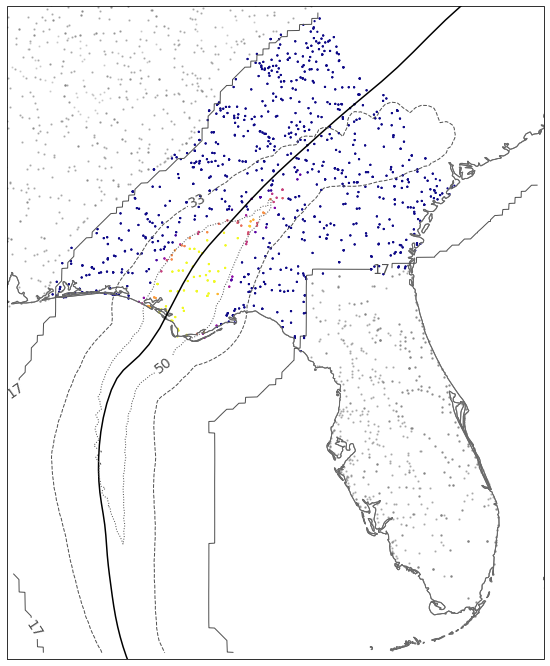

In [70]:
# Celltowers
gdf_ct_unexp, gdf_ct_exp = split_gdf_exp_unexp(gdf_all_nodes[bool_ct], shape)

f1, axes1 = plt.subplots(1, 1, figsize=(12, 12), squeeze=True, \
                             subplot_kw=dict(projection=ccrs.PlateCarree()))
axes1.set_extent((extent))
u_plot.add_shapes(axes1)
exposed_unexposed_plot(axes1, gdf_ct_unexp, gdf_ct_exp)
add_contour_windfield(tc_michael, tr_michael, axes1)

(<cartopy.mpl.contour.GeoContourSet at 0x2ab957b289a0>,
 [<matplotlib.lines.Line2D at 0x2ab957b28730>])

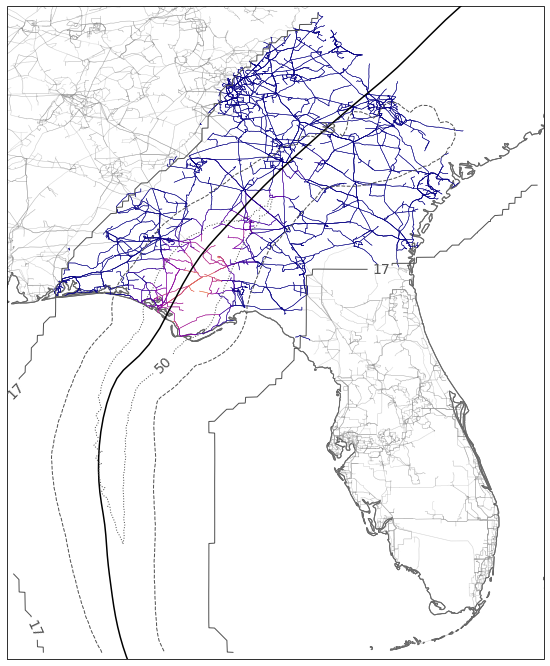

In [71]:
# Power Lines
gdf_pl_unexp, gdf_pl_exp = split_gdf_exp_unexp(gdf_all_edges[bool_pl], shape)

f1, axes1 = plt.subplots(1, 1, figsize=(12, 12), squeeze=True, \
                             subplot_kw=dict(projection=ccrs.PlateCarree()))
axes1.set_extent((extent))
u_plot.add_shapes(axes1)
exposed_unexposed_plot(axes1, gdf_pl_unexp, gdf_pl_exp, lines=True)
add_contour_windfield(tc_michael, tr_michael, axes1)

(<cartopy.mpl.contour.GeoContourSet at 0x2ab979e43640>,
 [<matplotlib.lines.Line2D at 0x2ab979e433d0>])

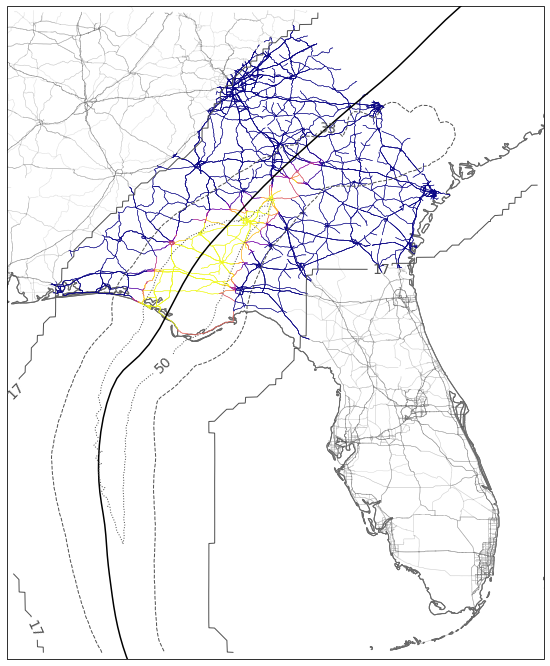

In [77]:
# Roads
gdf_rd_unexp, gdf_rd_exp = split_gdf_exp_unexp(gdf_all_edges[bool_rd][:len(gdf_road_edges)], shape)

f1, axes1 = plt.subplots(1, 1, figsize=(12, 12), squeeze=True, \
                             subplot_kw=dict(projection=ccrs.PlateCarree()))
axes1.set_extent((extent))
u_plot.add_shapes(axes1)
exposed_unexposed_plot(axes1, gdf_rd_unexp, gdf_rd_exp, lines=True)
add_contour_windfield(tc_michael, tr_michael, axes1)

In [78]:
# Some color definitions
col_cis = '#5d5866'
cmap_dmg = 'plasma'
cmap_casc =  ListedColormap(['#4169bf', '#BD574E', '#F6AE99']) #ListedColormap(['#4169bf', '#932c42','#c13a3d'])
cmap_serv = ListedColormap(['grey','#BB8082', '#046582']) # ListedColormap(['#ffd1a8', '#b7e3d9'])

In [79]:
np.where(gdf_all_edges[bool_pl]['distance']==max(gdf_all_edges[bool_pl]['distance']))

(array([ 4860, 11019]),)

In [80]:
len(gdf_all_edges[bool_pl])

13230

In [81]:
# exclude "power line" to import / export node in plots
index_excl = gdf_all_edges[bool_pl].iloc[
    np.where(gdf_all_edges[bool_pl]['distance']==max(gdf_all_edges[bool_pl]['distance']))].index
bool_pl[index_excl] = False

In [82]:
box_text = [fail_dict(count_failratios(gdf_all_edges.cascade[bools].values)) for bools in [bool_rd, bool_pl]]
box_text.extend([fail_dict(count_failratios(gdf_all_nodes.cascade[bools].values)) for bools in
               [bool_hc, bool_ed, bool_ct, bool_ww]])

### Big multi-panel figure (all steps)

/scratch/227967378.tmpdir/ipykernel_105628/3274405881.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  for ax, gdf in zip(axes.flatten()[[range(0,24,4)]], [gdf_road_edges, gdf_all_edges[bool_pl],
/scratch/227967378.tmpdir/ipykernel_105628/3274405881.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  for ax, bool_ci in zip(axes.flatten()[[range(9,24,4)]], [bool_hc, bool_ed, bool_ct, bool_ww]):
/scratch/227967378.tmpdir/ipykernel_105628/3274405881.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

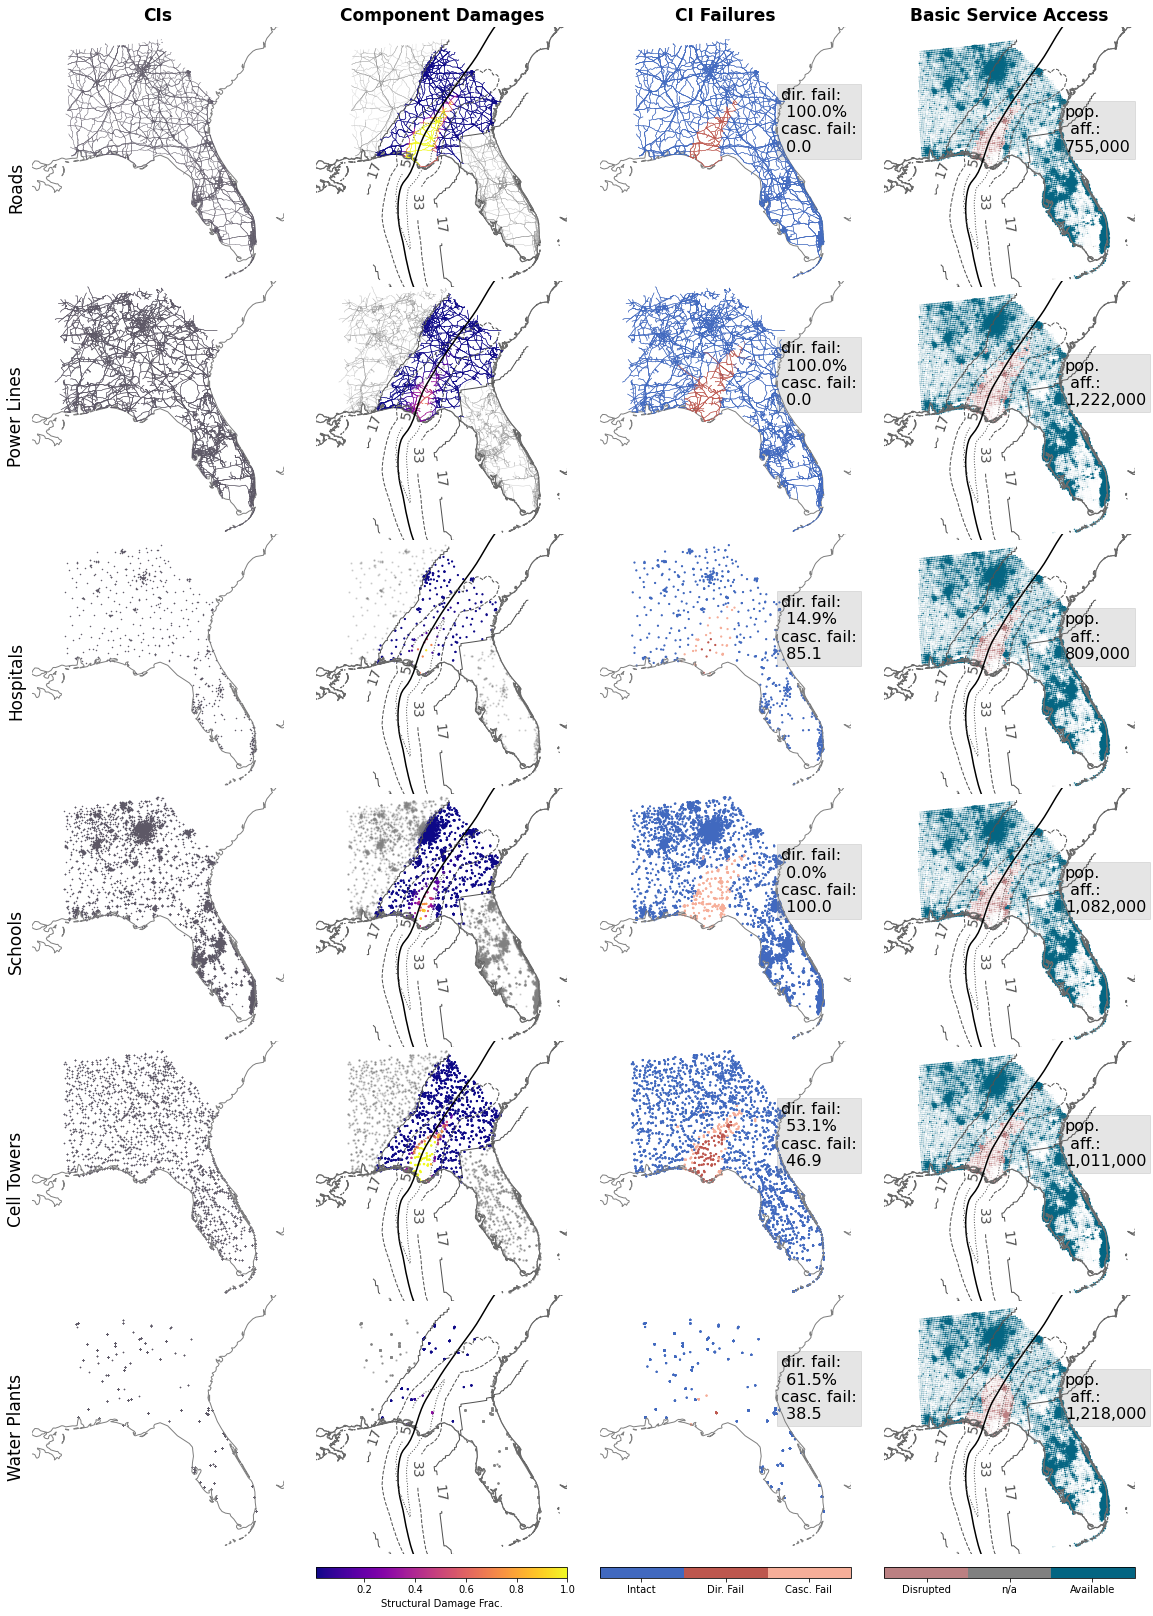

In [90]:
f, axes = plt.subplots(6, 4, subplot_kw=dict(projection=ccrs.LambertConformal()), figsize=(16,20*1.4142))

for ax in axes.flatten():
    ax.set_extent([-90, -79, 25, 35], ccrs.PlateCarree())
    ax.add_feature(border, facecolor='none', edgecolor='0.5')
    ax.axis('off')
    
# CIs
for ax, gdf in zip(axes.flatten()[[range(0,24,4)]], [gdf_road_edges, gdf_all_edges[bool_pl], 
                                                     gdf_all_nodes[bool_hc], gdf_all_nodes[bool_ed],
                                                     gdf_all_nodes[bool_ct], gdf_all_nodes[bool_ww]]):
    gdf.plot(ax=ax, markersize=1, linewidth=0.5, transform=ccrs.PlateCarree(), color=col_cis)

# Structural Damages
# road
ax = axes.flatten()[1]
gdf_rd_unexp, gdf_rd_exp = split_gdf_exp_unexp(gdf_all_edges[bool_rd][:len(gdf_road_edges)], shape)
exposed_unexposed_plot(ax, gdf_rd_unexp, gdf_rd_exp, lines=True)
add_contour_windfield(tc_michael, tr_michael, ax)
# power
ax = axes.flatten()[5]
gdf_pl_unexp, gdf_pl_exp = split_gdf_exp_unexp(gdf_all_edges[bool_pl], shape)
exposed_unexposed_plot(ax, gdf_pl_unexp, gdf_pl_exp, lines=True)
add_contour_windfield(tc_michael, tr_michael, ax)
# others
for ax, bool_ci in zip(axes.flatten()[[range(9,24,4)]], [bool_hc, bool_ed, bool_ct, bool_ww]):
    gdf_unexp, gdf_exp = split_gdf_exp_unexp(gdf_all_nodes[bool_ci], shape)
    h_dmg, __ = exposed_unexposed_plot(ax, gdf_unexp, gdf_exp, lines=False)
    add_contour_windfield(tc_michael, tr_michael, ax)

# Failure Cascades
box_text = [fail_dict(count_failratios(gdf_all_edges.cascade[bools].values)) for bools in [bool_rd, bool_pl]]
box_text.extend([fail_dict(count_failratios(gdf_all_nodes.cascade[bools].values)) for bools in
               [bool_hc, bool_ed, bool_ct, bool_ww]])

ax = axes.flatten()[2]
gdf_all_edges[bool_rd][:len(gdf_road_edges)].append(
    gdf_all_nodes[bool_rdn]).plot('cascade', ax=ax, cmap=cmap_casc, markersize=0,
                                                  linewidth=0.5, transform=ccrs.PlateCarree())
ax.text(0.72, 0.52, ''.join([f'{str(key)}:\n {str(val)}' + '\n' for key, val in box_text[0].items()])[:-2],
        transform=ax.transAxes, fontsize=16, bbox=dict(
                   ec='gray', fc='gray', alpha=0.2))

ax = axes.flatten()[6]
gdf_all_edges[bool_pl].append(
    gdf_all_nodes[bool_pln]).plot('cascade', ax=ax, cmap=cmap_casc, linewidth=0.5, markersize=0,
                                  transform=ccrs.PlateCarree())
ax.text(0.72, 0.52, ''.join([f'{str(key)}:\n {str(val)}' + '\n' for key, val in box_text[1].items()])[:-2],
        transform=ax.transAxes, fontsize=16, bbox=dict(
                   ec='gray', fc='gray', alpha=0.2))

for ax, bool_ci, text in zip(axes.flatten()[[range(10,24,4)]], [bool_hc, bool_ed, bool_ct, bool_ww], 
                      box_text[2:]):
    h_casc = ax.scatter(gdf_all_nodes[bool_ci].geometry.x, gdf_all_nodes[bool_ci].geometry.y, 
                        c=gdf_all_nodes[bool_ci].cascade, cmap=cmap_casc,
                        transform=ccrs.PlateCarree(), s=1.5)
    ax.text(0.72, 0.52, ''.join([f'{str(key)}:\n {str(val)}' + '\n' for key, val in text.items()])[:-2],
            transform=ax.transAxes, fontsize=16, bbox=dict(
                   ec='gray', fc='gray', alpha=0.2))
        
# Service Losses
box_text = [int(np.round(dict_disasterstats[service],-3)) for service 
            in ['mobility', 'power', 'healthcare', 'education','telecom', 'water']]
for ax, service, no in zip(axes.flatten()[[3,7,11,15,19,23]], 
                       ['actual_supply_road_people', 'actual_supply_power_line_people', 'actual_supply_health_people',
                        'actual_supply_education_people', 'actual_supply_celltower_people',
                        'actual_supply_wastewater_people'], box_text):
    h_serv = service_plot(gdf_all_nodes[bool_people], ax, service, 
                 f'{no:,}', cmap=ListedColormap(['#BB8082','gray','#046582']))
    add_contour_windfield(tc_michael, tr_michael, ax)

f.tight_layout()
f.subplots_adjust(bottom=0.1, top=0.85)   

# Titles
axes.flatten()[0].set_title('CIs', weight='bold', fontsize=17)
axes.flatten()[1].set_title('Component Damages', weight='bold', fontsize=17)
axes.flatten()[2].set_title('CI Failures', weight='bold', fontsize=17)
axes.flatten()[3].set_title('Basic Service Access', weight='bold', fontsize=17)

# Row-labels
for ax, ci in zip(axes.flatten()[[range(0,24,4)]], ['Roads', 'Power Lines', 'Hospitals', 
                                                    'Schools', 'Cell Towers', 'Water Plants']):
    ax.text(-0.1, 0.30, ci, transform=ax.transAxes, fontsize=17, rotation='vertical')

# Colorbars
cbar = mpu.colorbar(h_dmg, axes.flatten()[-3], size=0.04, pad=0.05, orientation='horizontal')
cbar.set_label('Structural Damage Frac.')

cbar = mpu.colorbar(h_casc, axes.flatten()[-2], size=0.04, pad=0.05, orientation='horizontal')
cbar.set_ticks([0.33, 1., 1.66])
cbar.set_ticklabels(['Intact', 'Dir. Fail', 'Casc. Fail'])

cbar = mpu.colorbar(h_serv, axes.flatten()[-1], size=0.04, pad=0.05, orientation='horizontal')
cbar.set_ticks([-0.66, 0, 0.66])
cbar.set_ticklabels(['Disrupted', 'n/a', 'Available'])

# Finish & Save
plt.savefig(PATH_SAVE_PLOTS+f'/multipanel_michael_{mode}.svg')

In [91]:
f.savefig(PATH_SAVE_PLOTS+f'/multipanel_michael_{mode}.pdf')

### Validation Plots

In [92]:
import matplotlib.patches as mpatches

In [93]:
path_celltowers = PATH_SAVE_PLOTS+'/ct_failures_valid.shp'

In [94]:
ct_fail = gpd.read_file(path_celltowers)

In [95]:
ct_fail['model_agr'] = ct_fail.model_agr*100
ct_fail['pout_model'] = ct_fail.pout_model*100
ct_fail['pout_rep'] = ct_fail.pout_rep*100

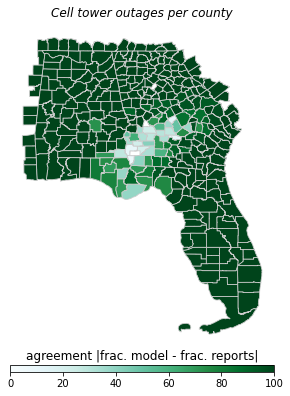

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
#axes.set_extent([-89, -80, 25, 35], ccrs.PlateCarree())
#axes.add_feature(border, facecolor='none', edgecolor='0.5')
ax.axis('off')
ct_fail.plot('model_agr', cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8', vmin=0, vmax=100)
h = ax.scatter(ct_fail.geometry.representative_point().x[:-2],
               ct_fail.geometry.representative_point().y[:-2],
               c=ct_fail.model_agr[:-2],
               s=0, cmap='BuGn', vmin=0, vmax=100)
cbar = mpu.colorbar(h, ax, ax, size=0.02, pad=0.05, orientation='horizontal')
cbar.ax.set_ylabel('[%]')
cbar.ax.set_title('agreement |frac. model - frac. reports|')
ax.set_title('Cell tower outages per county', style='oblique');

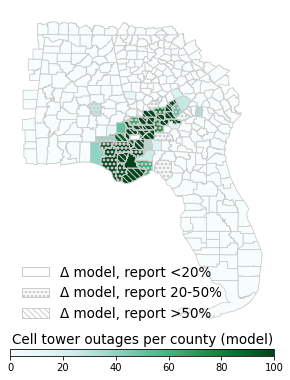

In [99]:
 hatch="//"
    
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
#axes.set_extent([-89, -80, 25, 35], ccrs.PlateCarree())
#axes.add_feature(border, facecolor='none', edgecolor='0.5')
ax.axis('off')
ct_fail.plot('pout_model', cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8', vmin=0, vmax=100)
ct_fail[(ct_fail.model_agr>=50)&(ct_fail.model_agr<80)].plot(linewidth=0.5, ax=ax, edgecolor='0.8', vmin=0, vmax=100, hatch='ooo', color='none')
ct_fail[ct_fail.model_agr<50].plot(linewidth=0.8, ax=ax, edgecolor='0.8', vmin=0, vmax=100, hatch='\\\\\\\\', color='none')

h = ax.scatter(ct_fail.geometry.representative_point().x[:-2],
               ct_fail.geometry.representative_point().y[:-2],
               c=ct_fail.model_agr[:-2],
               s=0, cmap='BuGn', vmin=0, vmax=100)
LegendElement = [mpatches.Patch(facecolor='w', hatch=None, edgecolor='0.8', label='Δ model, report <20%'),
                 mpatches.Patch(facecolor='w', hatch='ooo', edgecolor='0.8', label='Δ model, report 20-50%'),
                 mpatches.Patch(facecolor='w', hatch='\\\\\\\\', edgecolor='0.8', label='Δ model, report >50%'),
                ]
ax.legend(handles = LegendElement, loc='lower left', frameon=False, fontsize=13.5)
cbar = mpu.colorbar(h, ax, ax, size=0.02, pad=0.05, orientation='horizontal')
cbar.ax.set_ylabel('[%]')
cbar.ax.set_title('Cell tower outages per county (model)', fontsize=13.5);
plt.show()
fig.savefig(PATH_SAVE_PLOTS+'/celltower_validation.svg')

(array([  7.,   3.,   7.,  11.,   1.,   4.,   2.,  16.,  11.,  17., 303.]),
 array([  7.        ,  15.45454545,  23.90909091,  32.36363636,
         40.81818182,  49.27272727,  57.72727273,  66.18181818,
         74.63636364,  83.09090909,  91.54545455, 100.        ]),
 <BarContainer object of 11 artists>)

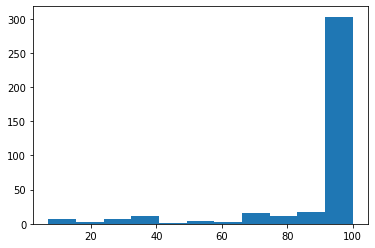

In [100]:
plt.hist(ct_fail.model_agr, bins=11)

In [118]:
path_power = PATH_SAVE_PLOTS+'/pow_failures_valid.shp'
gdf_pfail = gpd.read_file(path_power)

In [119]:
gdf_pfail

,State_Name,pout_model,pout_rep,geometry
0,Alabama,0.025058,0.0309,"POLYGON ((-88.13999 34.58170, -88.13997 34.581..."
1,Florida,0.028036,0.0368,"MULTIPOLYGON (((-86.39964 30.22696, -86.40262 ..."
2,Georgia,0.044321,0.0644,"POLYGON ((-85.38658 33.90172, -85.38659 33.901..."


In [120]:
gdf_pfail['model_agr'] = abs((gdf_pfail.pout_model/gdf_pfail.pout_rep)*100-100)
gdf_pfail.pout_model = gdf_pfail.pout_model*100
gdf_pfail.pout_rep = gdf_pfail.pout_rep*100

In [125]:
gdf_pfail['model_agr']

0    18.906886
1    23.814193
2    31.178612
Name: model_agr, dtype: float64

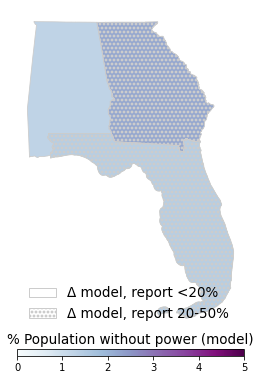

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.axis('off')
gdf_pfail.plot('pout_model', cmap='BuPu', linewidth=0.8, ax=ax, edgecolor='0.8', vmin=0, vmax=10)
gdf_pfail[(gdf_pfail.model_agr>=20)&(gdf_pfail.model_agr<50)].plot(linewidth=0.5, ax=ax, edgecolor='0.8', hatch='ooo', color='none')
#gdf_pfail[gdf_pfail.model_agr>50].plot(linewidth=0.8, ax=ax, edgecolor='0.8', hatch='\\\\\\\\', color='none')

h = ax.scatter(gdf_pfail.geometry.representative_point().x,
               gdf_pfail.geometry.representative_point().y,
               c=gdf_pfail.model_agr,
               s=0, cmap='BuPu', vmin=0, vmax=5)
LegendElement = [mpatches.Patch(facecolor='w', hatch=None, edgecolor='0.8', label='Δ model, report <20%'),
                 mpatches.Patch(facecolor='w', hatch='ooo', edgecolor='0.8', label='Δ model, report 20-50%'),
                 ]
ax.legend(handles = LegendElement, loc='lower left', frameon=False, fontsize=13.5)
cbar = mpu.colorbar(h, ax, ax, size=0.02, pad=0.05, orientation='horizontal',)
cbar.ax.set_ylabel('[%]')
cbar.ax.set_title('% Population without power (model)', fontsize=13.5);
plt.show()
fig.savefig(PATH_SAVE_PLOTS+'/power_validation.svg')

In [134]:
path_hc_dmg = PATH_SAVE_PLOTS+'/healthfacilities_dmg.shp'
gdf_hc_dmg = gpd.read_file(path_hc_dmg)
path_hc_inc = PATH_SAVE_PLOTS+'/health_incidents.shp'
gdf_hc_inc = gpd.read_file(path_hc_inc)
path_hc_mod = PATH_SAVE_PLOTS+'/healthcare_loss_model.shp'
gdf_hc_mod = gpd.read_file(path_hc_mod)

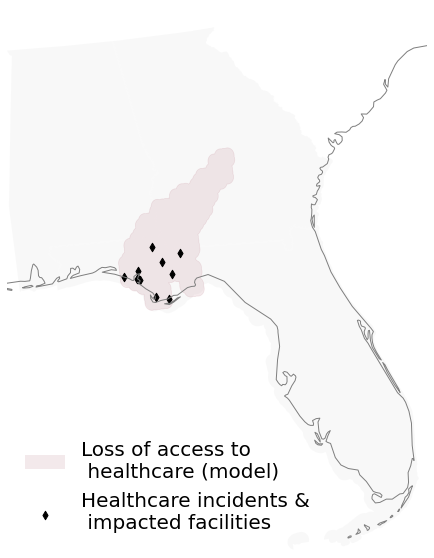

In [135]:
f, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.LambertConformal()), figsize=(10,10))
ax.set_extent([-88.2, -80, 25, 35], ccrs.PlateCarree())
ax.add_feature(border, facecolor='none', edgecolor='0.5')
ax.axis('off')
h1 = gdf_pfail.plot(color='gray', ax=ax, edgecolor='1', alpha=0.05, transform=ccrs.PlateCarree())
h2 = gdf_hc_mod.buffer(0.05).plot(ax=ax, linewidth=0.8, edgecolor='#932c42', color='#932c42', alpha=0.1,transform=ccrs.PlateCarree())
h3 = ax.scatter(gdf_hc_inc.geometry.x,gdf_hc_inc.geometry.y, marker='d', facecolors='k', edgecolors='k', transform=ccrs.PlateCarree(),
               label='Healthcare incidents & \n impacted facilities' )
h4 = ax.scatter(gdf_hc_dmg.geometry.x,gdf_hc_dmg.geometry.y, marker='d', facecolors='k', edgecolors='k',transform=ccrs.PlateCarree(),
               label='Healthcare Incidents')

LegendElement = [mpatches.Patch(facecolor='#932c42', edgecolor=None, alpha=0.1,label='Loss of access to \n healthcare (model)'),
                  ]
ax.legend(handles = [*LegendElement, h3], loc='lower left', frameon=False, fontsize=20)
plt.show()
f.savefig(PATH_SAVE_PLOTS+'/health_validation.svg')

In [139]:
path_rd_dmg = PATH_SAVE_PLOTS+'/road_dmg.shp'
path_rd_inc = PATH_SAVE_PLOTS+'/road_incidents.shp'
path_rd_mod = PATH_SAVE_PLOTS+'/mobility_loss_model.shp'

gdf_rd_dmg = gpd.read_file(path_rd_dmg)
gdf_rd_inc = gpd.read_file(path_rd_inc)
gdf_rd_mod = gpd.read_file(path_rd_mod)

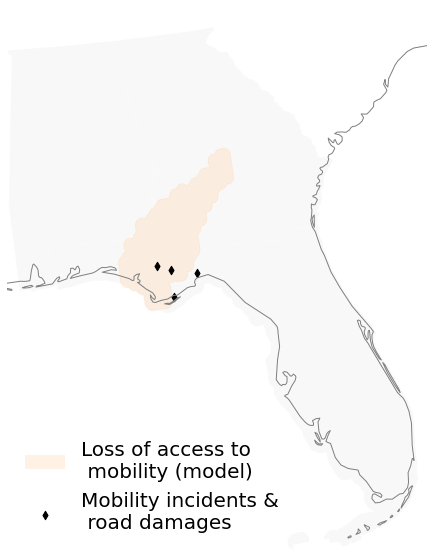

In [140]:
f, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.LambertConformal()), figsize=(10,10))
ax.set_extent([-88.2, -80, 25, 35], ccrs.PlateCarree())
ax.add_feature(border, facecolor='none', edgecolor='0.5')
ax.axis('off')
h1 = gdf_pfail.plot(color='gray', ax=ax, edgecolor='1', alpha=0.05, transform=ccrs.PlateCarree())
h2 = gdf_rd_mod.buffer(0.05).plot(ax=ax, linewidth=0.8, edgecolor='#ffd1a8', color='#ffd1a8', alpha=0.3,transform=ccrs.PlateCarree())
h3 = ax.scatter(gdf_rd_inc.geometry.x, gdf_rd_inc.geometry.y, marker='d', facecolors='k', edgecolors='k', transform=ccrs.PlateCarree(),
               label='Mobility incidents & \n road damages')
h4 = ax.scatter(gdf_rd_dmg.geometry.x,gdf_rd_dmg.geometry.y, marker='d', facecolors='k', edgecolors='k',transform=ccrs.PlateCarree(),
               label='Mobility loss')
LegendElement = [mpatches.Patch(facecolor='#ffd1a8', edgecolor=None, alpha=0.3,label='Loss of access to \n mobility (model)'),
                  ]
ax.legend(handles = [*LegendElement, h3], loc='lower left', frameon=False, fontsize=20)
plt.show()
f.savefig(PATH_SAVE_PLOTS+'/mobility_validation.svg')

In [141]:
path_ww_dmg = PATH_SAVE_PLOTS+'/water_incidents.shp'
path_water_mod = PATH_SAVE_PLOTS+'/water_loss_model.shp'

gdf_ww_dmg = gpd.read_file(path_ww_dmg)
gdf_ww_mod = gpd.read_file(path_water_mod)

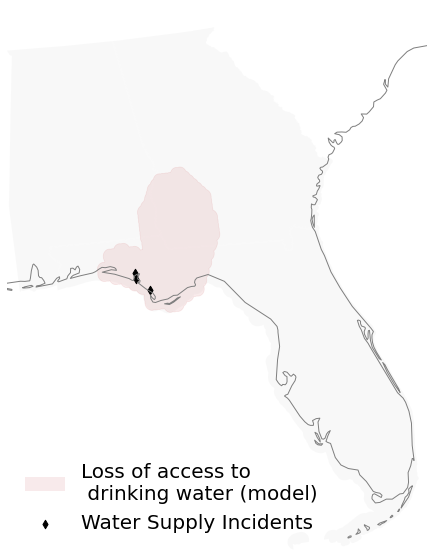

In [143]:
f, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.LambertConformal()), figsize=(10,10))
ax.set_extent([-88.2, -80, 25, 35], ccrs.PlateCarree())
ax.add_feature(border, facecolor='none', edgecolor='0.5')
ax.axis('off')
h1 = gdf_pfail.plot(color='gray', ax=ax, edgecolor='1', alpha=0.05, transform=ccrs.PlateCarree())
h2 = gdf_ww_mod.buffer(0.05).plot(ax=ax, linewidth=0.8, edgecolor='#c13a3d', color='#c13a3d', alpha=0.1,transform=ccrs.PlateCarree())
h3 = ax.scatter(gdf_ww_dmg.geometry.x, gdf_ww_dmg.geometry.y, marker='d', facecolors='k', edgecolors='k', transform=ccrs.PlateCarree(),
               label='Water Supply Incidents')
LegendElement = [mpatches.Patch(facecolor='#c13a3d', edgecolor=None, alpha=0.1,label='Loss of access to \n drinking water (model)'),
                  ]
ax.legend(handles = [*LegendElement, h3], loc='lower left', frameon=False, fontsize=20)
plt.show()
f.savefig(PATH_SAVE_PLOTS+'/water_validation.svg')

In [145]:
path_educ_dmg = PATH_SAVE_PLOTS+'/educ_incidents.shp'
path_educ_mod = PATH_SAVE_PLOTS+'/educ_loss_model.shp'

gdf_educ_dmg = gpd.read_file(path_educ_dmg)
gdf_educ_mod = gpd.read_file(path_educ_mod)

In [50]:
gdf_educ_dmg

,FID,geometry
0,0,POINT (-84.87945 30.29558)
1,1,POINT (-85.70833 30.30878)
2,2,POINT (-85.18208 30.40275)
3,3,POINT (-85.24247 30.78727)
4,4,POINT (-84.64051 30.57325)
5,5,POINT (-85.23135 29.94861)
6,6,POINT (-84.80321 29.91163)
7,7,POINT (-85.66790 30.60080)


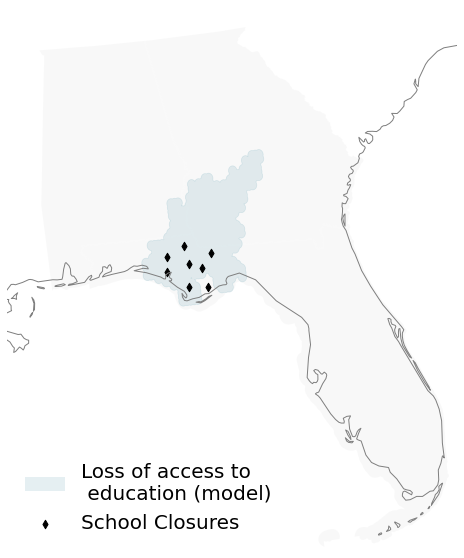

In [146]:
f, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.LambertConformal()), figsize=(10,10))
ax.set_extent([-89, -80, 25, 35], ccrs.PlateCarree())
ax.add_feature(border, facecolor='none', edgecolor='0.5')
ax.axis('off')
h1 = gdf_pfail.plot(color='gray', ax=ax, edgecolor='1', alpha=0.05, transform=ccrs.PlateCarree())
h2 = gdf_educ_mod.plot(ax=ax, linewidth=0.8, edgecolor='#046582', color='#046582',  alpha=0.1,transform=ccrs.PlateCarree())
h3 = ax.scatter(gdf_educ_dmg.geometry.x, gdf_educ_dmg.geometry.y, marker='d', facecolors='k', edgecolors='k', transform=ccrs.PlateCarree(),
               label='School Closures')
LegendElement = [mpatches.Patch(facecolor='#046582', edgecolor=None, alpha=0.1,label='Loss of access to \n education (model)'),
                  ]
ax.legend(handles = [*LegendElement, h3], loc='lower left', frameon=False, fontsize=20)
plt.show()
f.savefig(PATH_SAVE_PLOTS+'/educ_validation.svg')